
# Elección de la mejor predición


VAmos a trabajar con las sigueinte  __Series de tiempos __ que nos da ventas mensuales de coles en Quebec desde 1960 hasta 1968. Este dataset puede ser bajado de aquí: 

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

El objetivo de este notebook es explorar diferentes modelos para predecir 
las ventas futuras. 

Seguiremos los siguientes pasos:

1. Preparación de datos.
2. Separar los datos en entrenamiento, test y validación.
3. Construir los diferentes modelos.
4. Ajustar los modelos o a los datos de entrenamiento.
5. Evaluar cada modelo en el conjunto de valildación y elegir el mejor.
6. Evaluar el modelo en el conjunto de test.

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

### Preparación de datos

In [4]:
cars_df = pd.read_csv("data/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


Limpiamos última fila

In [6]:
cars_df = cars_df.iloc[:-1]

Cambiamos el formato de las fechas

In [7]:
cars_df["dt"] = cars_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

Renombramos la columna `Monthly car sales in Quebec 1960-1968` por  `sales` y eliminamos la columna `Month`.

In [8]:
cars_df = cars_df\
    .rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)\
    .drop("Month", axis=1)
cars_df.tail()

,sales,dt
103,16722.0,1968-08-01
104,14385.0,1968-09-01
105,21342.0,1968-10-01
106,17180.0,1968-11-01
107,14577.0,1968-12-01


Dibujamos nuestra serie de tiempos:

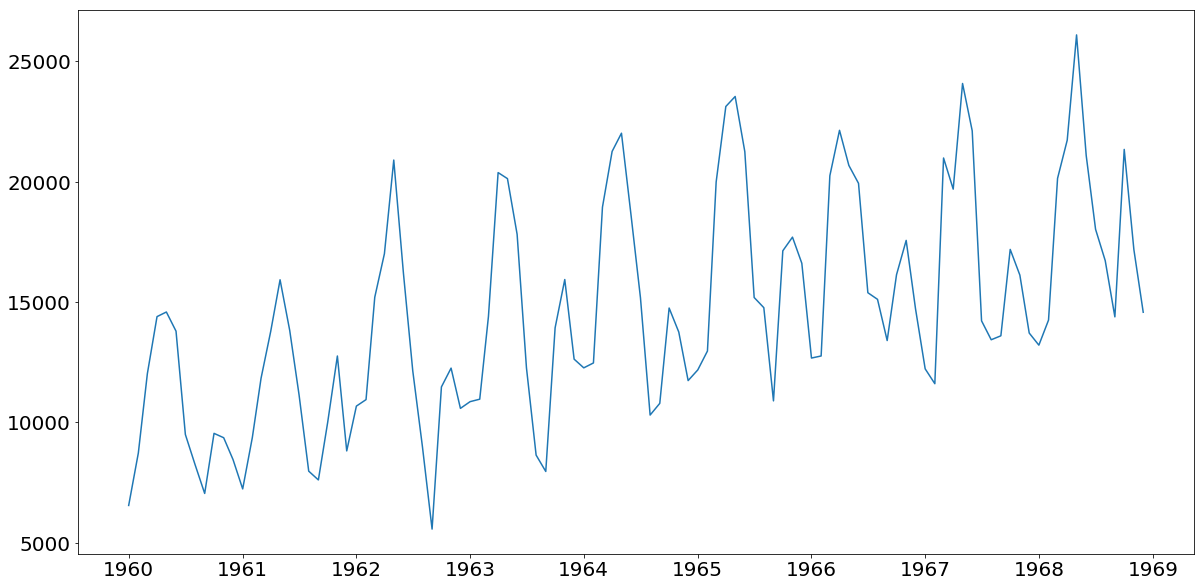

In [13]:
plt.plot(cars_df["dt"], cars_df["sales"])

Verificamos que tenemos datos de todos los meses:

In [14]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Separar los datos en entrenamiento, test y validación.


* Mucho cuidado que cuando trabajamos series de tiempos no podemos hacer el split aleatoriamente ya que se trata de predecir datos a futuro. Por tanto tenemos respetar que el conjunto de validación y test son usando datos posteriores al conjunto de entrenamiento.

In [15]:
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Modelo 1: media de las anteriores ventas


Un simple modelo es predecir a futuro el valor de la media de los datos anteriores.

In [16]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

Dibujamos su performance

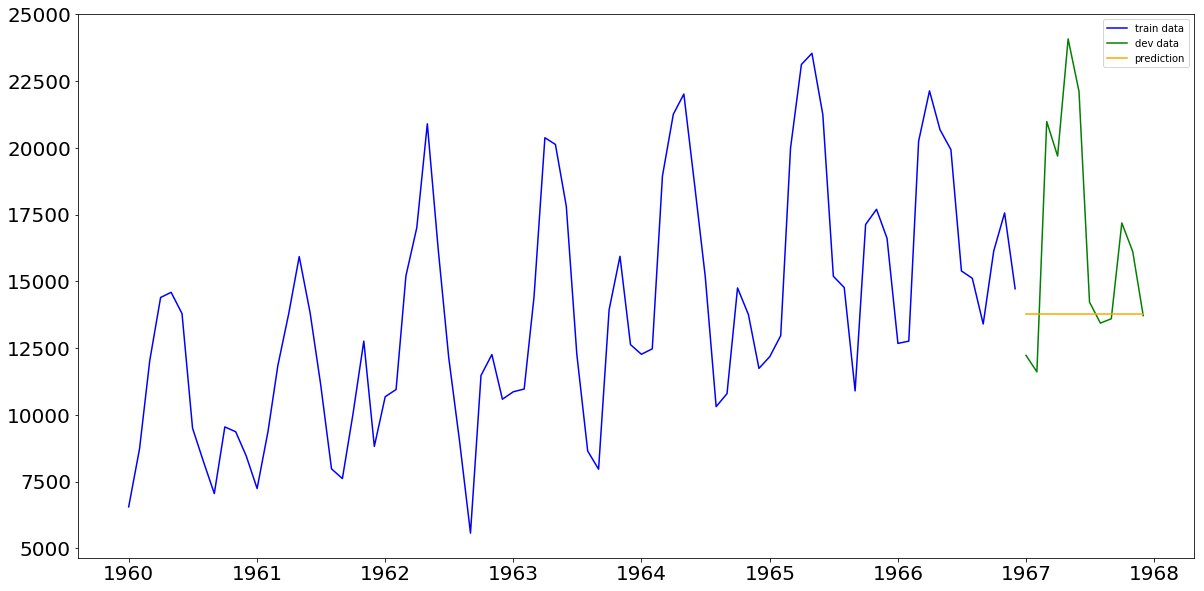

In [17]:
def plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat):
    plt.plot(X_train["dt"], y_train, c="blue", label='train data')
    plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
    plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
    plt.legend()
    plt.show()
    
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

Vemos que la predición no es buena, pero nos sirve para tener un __baseline__, un punto de comienzo para ir mejorando con otros modelos.

Para la evaluación del performance del modelo usaremos el error cuadrático medio, MSE, y su raiz, RSME que nos servirán para elegir el mejor modelo.

In [18]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  23847172.57993197
RMSE:  4883.356691859808


## Modelo 2: media del año anterior

Vamos a tomar la media de los últimos doce meses

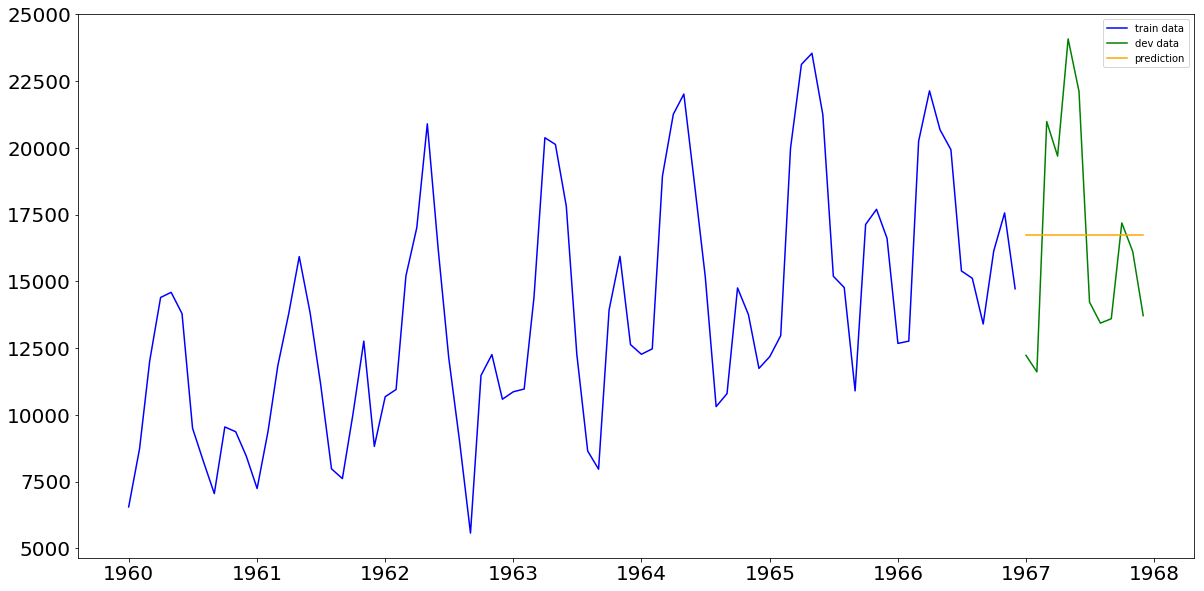

In [20]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

This time it looks better.

In [15]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

##  Modelo 3: valor del mes anterior


A menudo, para predecir el valor del siguiente mes, usamos el valor del anterior mes. Para ello vamos a añadir una nueva feature que nos da el valor del mes anterior usando el método en python llamado `shift`. esto es llamado __lag__.

In [22]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head(3)

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0


In [23]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

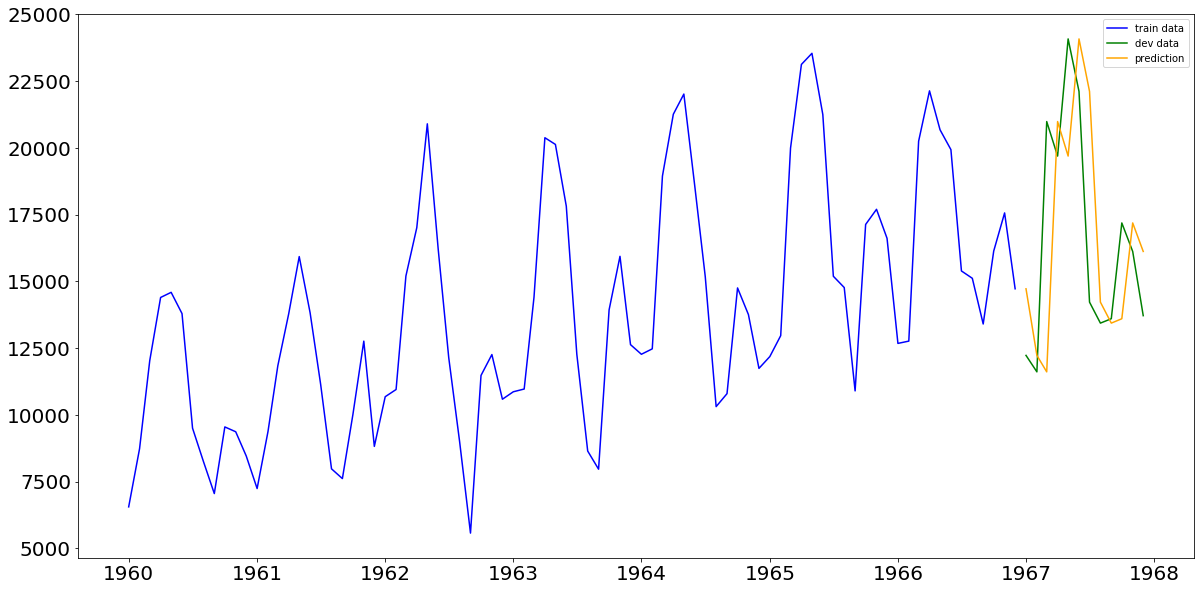

In [25]:
y_dev_hat = X_dev['sales-1']
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [26]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

##  Modelo 4: modelo de Autoregresion (AR)


Es calro que los datos de Diciembre de un año y el anterior. Vamos a calcula si es cierto haciendo la función de correlación entre un meriodo y el de un año anterior (usaremos lags).

In [36]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['sales']

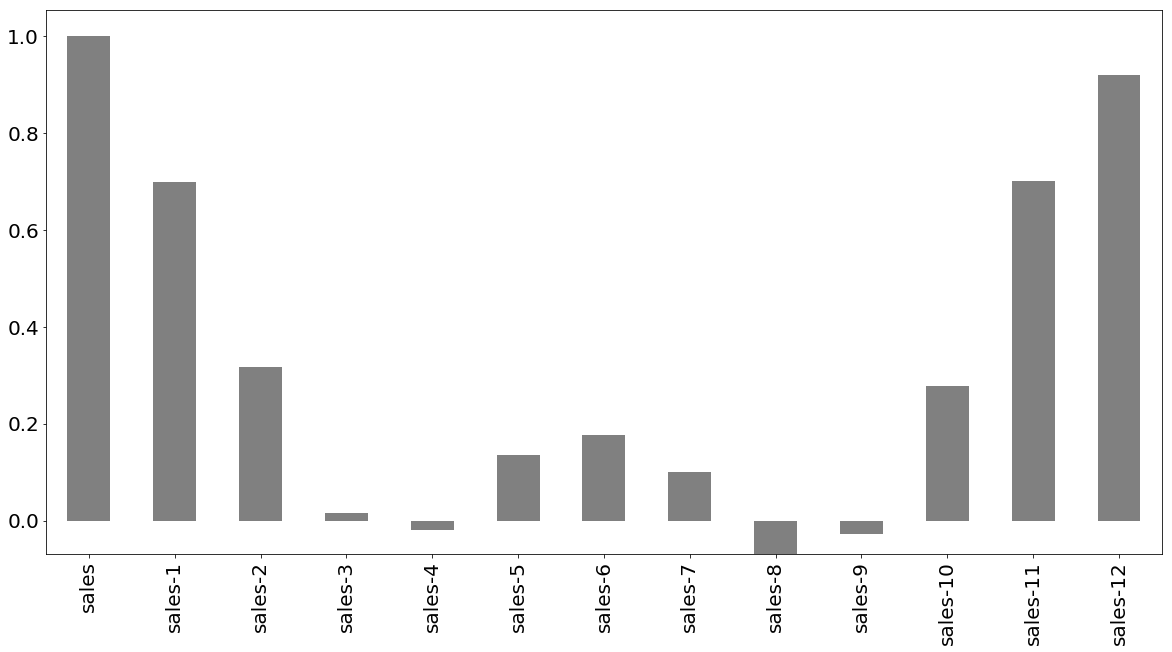

In [54]:
autocorrelations.plot(kind='bar',color='gray')

Elegimos las columnas que son más correladas con sales.

In [55]:
columns_for_ar = autocorrelations[np.abs(autocorrelations) > 0.15].index[1:]
columns_for_ar

Index(['sales-1', 'sales-2', 'sales-6', 'sales-10', 'sales-11', 'sales-12'], dtype='object')

eliminamos los Nas de los lags

In [57]:
Xy_with_lags.head(3)

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1960-01-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:].reset_index(drop=True)
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1961-01-01,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
1,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
2,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
3,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
4,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [59]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression

def train_and_test_linear_model(X_train, y_train, X_dev, y_dev):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_dev_hat = reg.predict(X_dev)
    return reg, np.sqrt(mean_squared_error(y_dev, y_dev_hat))


reg, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

y_dev_hat = reg.predict(X_dev.drop("dt", axis=1)[columns_for_ar])
rmse

2014.659693608687

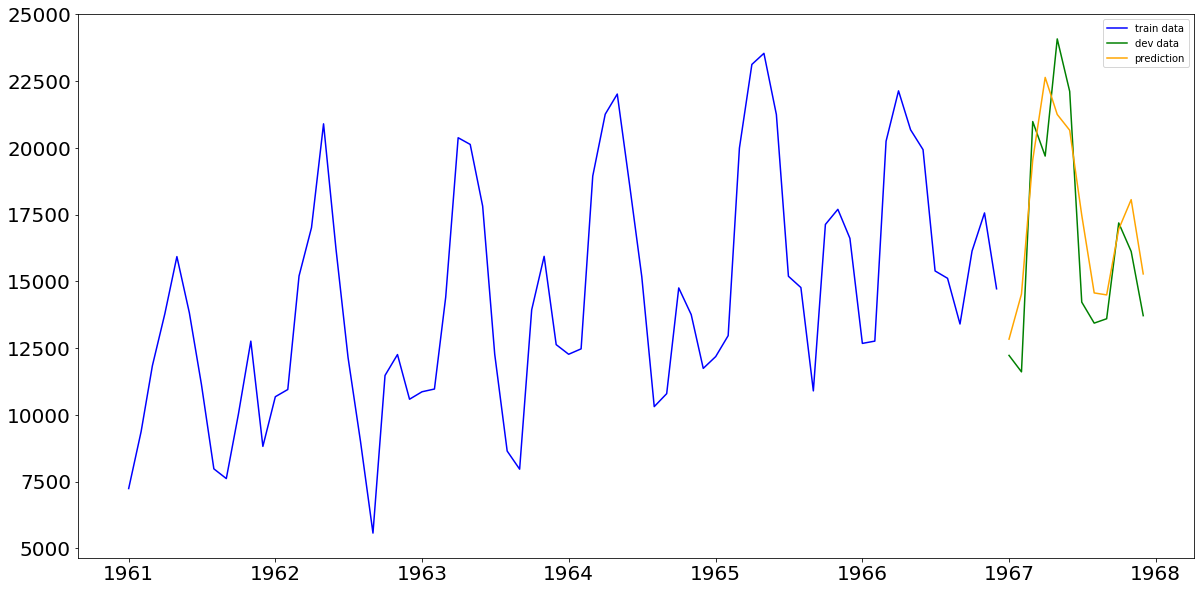

In [60]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

Ahora hemos mejorado más que el doble!!!!

COjamos ahora todos los úktimos 12 meses

In [64]:
columns_for_ar = ["sales-" + str(i) for i in range(1, 13)]

reg_all_columns, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

rmse

2009.4533750232401

##  Modelo 5: modelo recurrente 

A menudo en la práctica nosotros buscamos una predición para todo el año. Vamos a asumir que estmaos en Enero de 1967 y nos gustaria tener una previsión par todos los meses de 1967 y así la empresa podría optimizar el stock mensual.

Podemos hacer lo mismo que en el modelo anterior pero usando las prediciones anteriores. Esto significa que para predecir Abril usaremos los ultimos 12 meses últimos, tomando para Enero, Febreo y Marzo los datos de predicion. 

In [65]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

y_dev_hat = recurrent_prediction(y_train, 12, reg_all_columns)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1894.014570375845

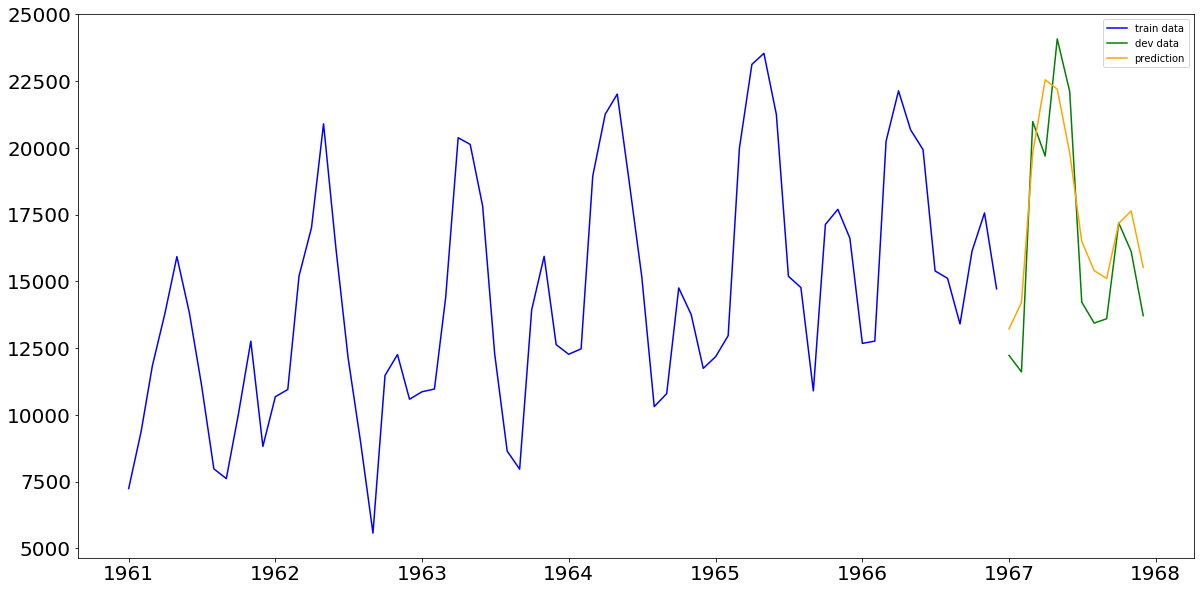

In [67]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

##  Modelo 6: K-nearest neighborhood 

In [76]:
from sklearn.neighbors import KNeighborsRegressor

N_lags = 12
Xy_with_lags = create_lags(Xy, N_lags).iloc[N_lags:]
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

reg_kn = KNeighborsRegressor(n_neighbors=5)
reg_kn.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1664.4863111482778

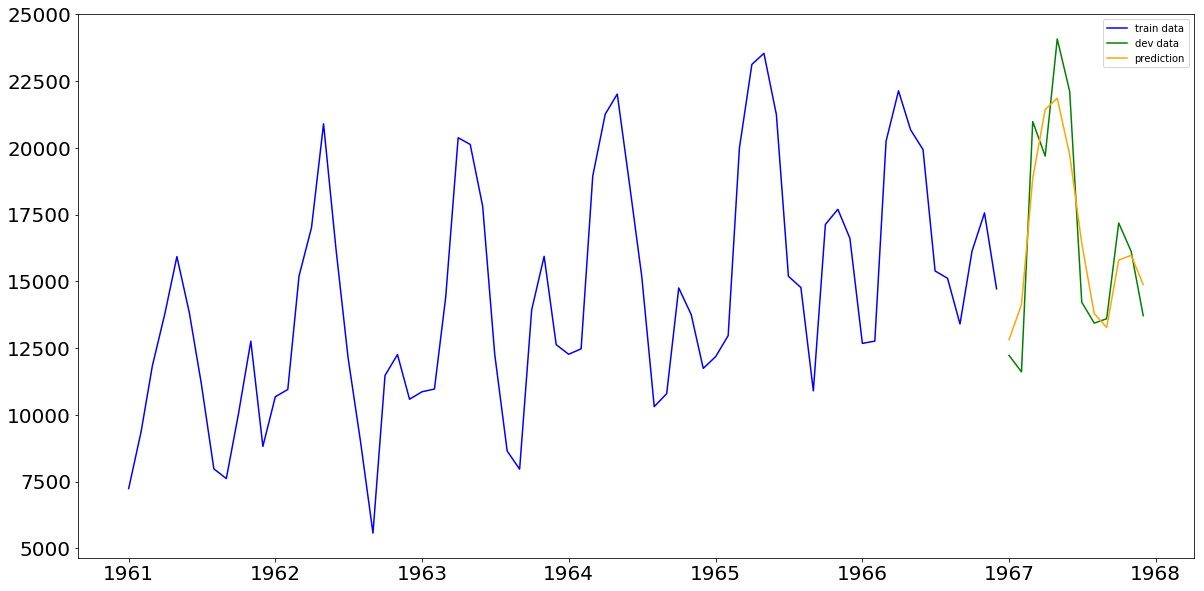

In [77]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

 Grid search of best parameters

In [79]:
performance = pd.DataFrame()   

for n_neighbors in [2, 3, 4, 5, 6, 7, 8]:
    reg_kn = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg_kn.fit(X_train.drop("dt", axis=1), y_train)
    y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
    rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
    new_row = pd.DataFrame({
        "n_neighbours": [n_neighbors], 
        "rmse": [rmse]
    })
    performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,n_neighbours,rmse
0,2,1557.793197
2,4,1659.930914
3,5,1664.486311
6,8,1838.954597
1,3,1866.014777


##  Modelo 7: Random Forest

In [80]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


reg_rf = RandomForestRegressor(random_state=667)
reg_rf.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

/Users/CotePelaez/anaconda/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


1563.6772125346079

In [81]:
performance = pd.DataFrame()   

for n_estimators in [2, 5, 7, 10, 20, 100]:
    for max_depth in [5, 7, 10, 20]:
        reg_kn = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=667)
        reg_kn.fit(X_train.drop("dt", axis=1), y_train)
        y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
        rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
        new_row = pd.DataFrame({
            "n_estimators": [n_estimators], 
            "max_depth": [max_depth],
            "rmse": [rmse]
        })
        performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,max_depth,n_estimators,rmse
11,20,7,1515.355936
8,5,7,1519.197094
14,10,10,1555.179317
15,20,10,1563.677213
12,5,10,1576.342980


In [82]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

reg_rf = RandomForestRegressor(n_estimators=7, max_depth=20, random_state=667)
reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_test, y_test_hat))

2159.4251868854135

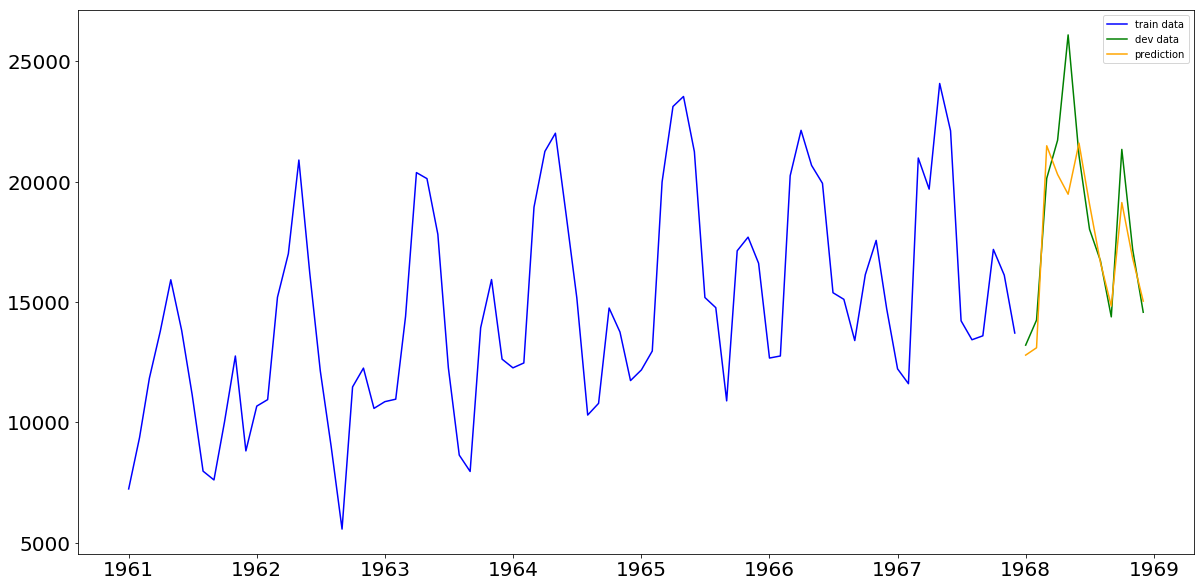

In [84]:
plot_predicition(X_train_dev, y_train_dev, X_test, y_test, y_test_hat)

## Modelo 8: Autoregression (AR) 

In [85]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1773.1012131860994


/Users/CotePelaez/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/CotePelaez/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


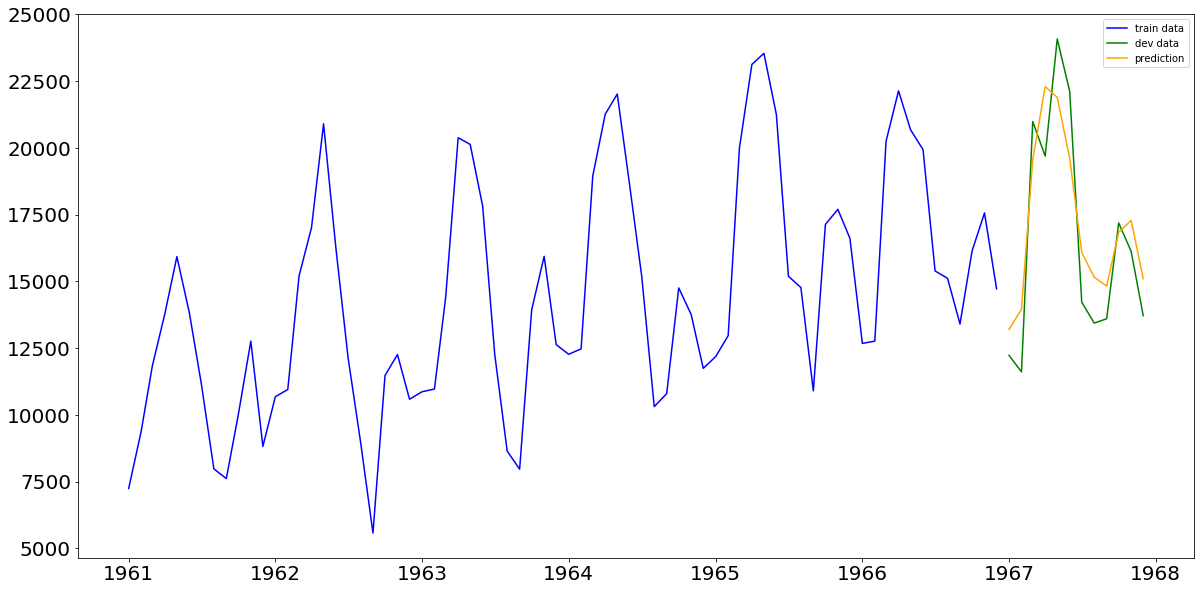

In [87]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Modelo 8: Autoregression Moving Average (ARIMA) 

In [88]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/Users/CotePelaez/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/CotePelaez/anaconda/lib/python3.5/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [89]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

2188.1997655140203


/Users/CotePelaez/anaconda/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


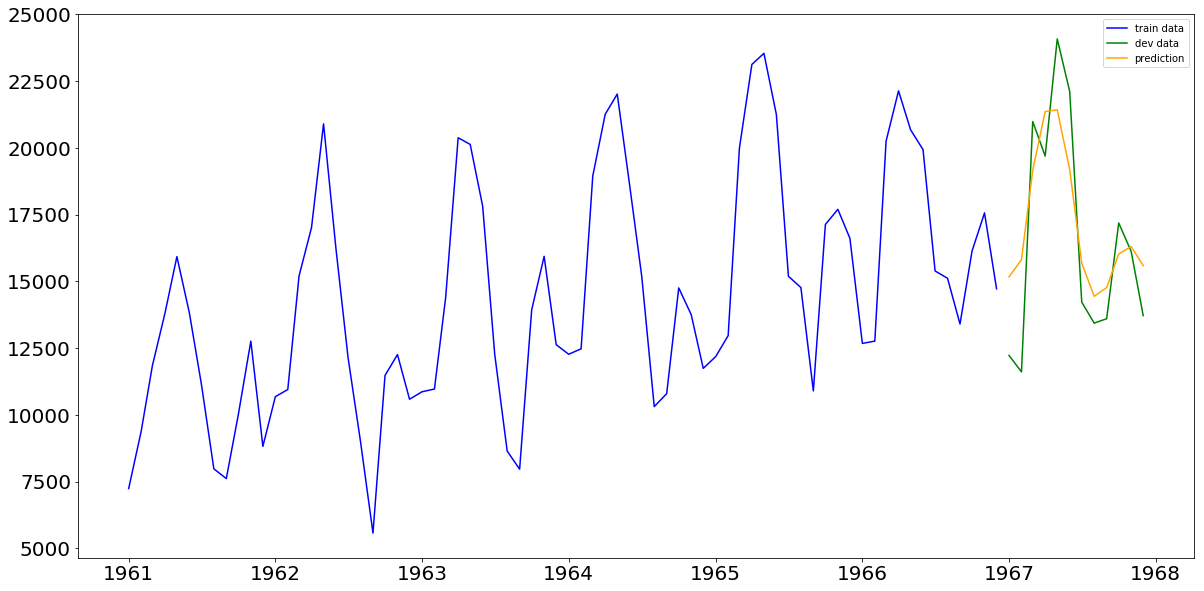

In [91]:
plot_predicition(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
